In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

In [3]:
# Sample dataset with multiple genres per movie
movies = pd.read_csv('movie.csv')

# Convert the genre column into a list of genres
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

# Step 1: Apply MultiLabelBinarizer on Genre
mlb = MultiLabelBinarizer()
encoded_genres = mlb.fit_transform(movies['genres'])

# Convert encoded genres into a DataFrame
genre_labels = mlb.classes_  # Get genre column names
genre_df = pd.DataFrame(encoded_genres, columns=genre_labels)

# Step 2: Merge Encoded Genres with Original Data
movies = pd.concat([movies.drop(columns=['genres']), genre_df], axis=1)

# Step 3: Extract feature vectors (excluding movie names)
X = movies.drop(columns=['userId','movieId','rating_timestamp','tag','tag_timestamp','title','imdbId','tmdbId'])


# Step 4: Standardize numerical features (Rating, Year)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [33]:
print(X.columns)

Index(['rating', '(no genres listed)', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


In [ ]:
# # Determine the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.show()

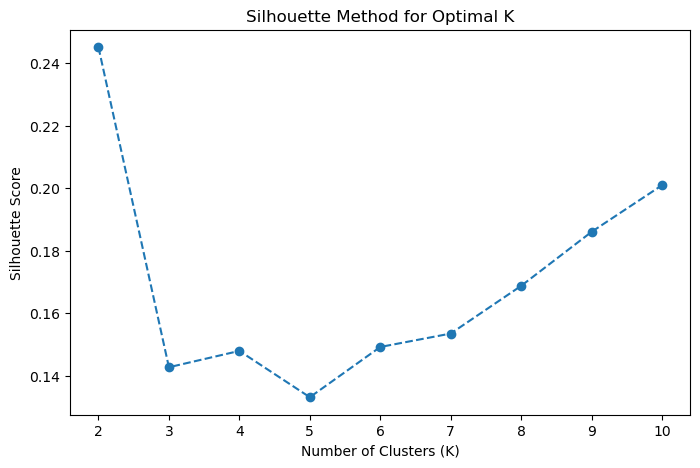

Optimal number of clusters: 2


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 11)  # Start from 2 since silhouette score isn't defined for K=1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)

# Plot the Silhouette Score vs K
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal K')
plt.show()

# Get the best K (where silhouette score is highest)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")


In [9]:
for k in range(3, 6):  # Try 3 to 5 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, cluster_labels)
    print(f"K={k}, Silhouette Score: {silhouette}")

K=3, Silhouette Score: 0.14266626662460363


KeyboardInterrupt: 

In [11]:
# Set optimal number of clusters (Assuming elbow method suggests K=3)
optimal_k = 2

# Train K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
movies['Cluster'] = kmeans.fit_predict(X_scaled)

# Save the trained K-Means model, scaler, and MultiLabelBinarizer
with open("kmeans_model.pkl", "wb") as model_file:
    pickle.dump(kmeans, model_file)

with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

with open("mlb.pkl", "wb") as mlb_file:
    pickle.dump(mlb, mlb_file)

print("Model, Scaler, and MultiLabelBinarizer Saved Successfully!")


Model, Scaler, and MultiLabelBinarizer Saved Successfully!


In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies(movie_name, movies_df, kmeans_model, scaler_model, mlb_model, top_n=10):
    # List of all genre columns used during training
    genre_columns = ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                     'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
                     'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

    relevant_columns = ['rating','(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                     'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
                     'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

    # Get the row for the input movie
    movie_row = movies_df[movies_df['title'] == movie_name]

    if movie_row.empty:
        return f"Movie '{movie_name}' not found in dataset."

    # Select the relevant features
    movie_features = movie_row[relevant_columns].copy()

    # Ensure all required columns exist (fill missing ones with 0)
    for col in relevant_columns:
        if col not in movie_features.columns:
            movie_features[col] = 0  

    # Ensure the order of features matches the scaler training order
    movie_features = movie_features[relevant_columns]

    # Convert DataFrame to NumPy array before scaling
    movie_features_np = movie_features.to_numpy()

    # Scale the movie features using the same scaler
    movie_scaled = scaler_model.transform(movie_features_np)

    # Predict the cluster of the given movie
    movie_cluster = kmeans_model.predict(movie_scaled)[0]

    # Get movies in the same cluster
    cluster_movies = movies_df[movies_df['Cluster'] == movie_cluster].copy()

    # Ensure cluster_movies also contains the correct feature order
    cluster_movie_features = cluster_movies[relevant_columns].copy()
    cluster_movie_features_np = cluster_movie_features.to_numpy()

    # Compute cosine similarity
    similarities = cosine_similarity(movie_scaled, scaler_model.transform(cluster_movie_features_np)).flatten()

    # Get sorted indices of the most similar movies (excluding itself)
    sorted_indices = np.argsort(similarities)[::-1]  # Sort in descending order

    # Get unique movie indices while excluding the input movie
    unique_indices = []
    for idx in sorted_indices:
        if idx < len(cluster_movies) and cluster_movies.iloc[idx]['title'] != movie_name:
            unique_indices.append(idx)
        if len(unique_indices) >= top_n:
            break  # Stop once we have enough recommendations

    # Ensure we have valid indices before using iloc
    if not unique_indices:
        return f"No similar movies found for '{movie_name}'. Try a different movie."

    # Get movie titles of unique most similar movies
    similar_movies = cluster_movies.iloc[unique_indices][['title', 'rating']]

    return similar_movies

# Example: Get recommendations
print(recommend_movies('Close Range (2015)', movies, loaded_kmeans, loaded_scaler, loaded_mlb, top_n=10))


                                   title  rating
36439   Run Lola Run (Lola rennt) (1998)     3.0
14657              Batman Returns (1992)     3.0
92604            Italian Job, The (2003)     3.0
40955        From Paris with Love (2010)     3.0
40897                  RocknRolla (2008)     3.0
70168            Italian Job, The (2003)     3.0
102190                 RocknRolla (2008)     3.0
24191   Run Lola Run (Lola rennt) (1998)     3.0
23753              Batman Returns (1992)     3.0
52090          Gone in 60 Seconds (2000)     3.0


C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [23]:
print(movies.columns)

Index(['userId', 'movieId', 'rating', 'rating_timestamp', 'tag',
       'tag_timestamp', 'title', 'imdbId', 'tmdbId', '(no genres listed)',
       'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'Cluster'],
      dtype='object')


In [43]:
# Count movies in each cluster
cluster_counts = movies['Cluster'].value_counts()
print(cluster_counts)

Cluster
0    92385
1    10292
Name: count, dtype: int64
